In [174]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D, LSTM
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import copy
from tensorflow.keras import backend as K
from sklearn import preprocessing
import tensorflow.keras.optimizers as optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

## Separate splits

In [2]:
def augument_sample(sample, averages, stds):
    return None

def format_data(df, lookback_window=12, only_features=False, to_drop=['total_cases'], lstm=False):
    x = []
    y = []
    x_data = df.copy()
    
    if only_features:
        x_data = x_data.drop(to_drop, axis=1)

    for i in range(len(df)-lookback_window):
        x_entry = copy(x_data[i:i+lookback_window].values.T) # include current value
        
        if not only_features:
            x_entry[0][lookback_window-1] = 0.0 # erase variable to be predicted
        
        if lstm:
            x.append(x_entry.T)
        else:
            x.append(x_entry)

        y_entry = df['total_cases'][i+lookback_window-1]
        y.append(y_entry)
        
    x = np.array(x)
    y = np.array(y)
    return x, y

In [3]:
def split(x, y, val_size):
    train_size = len(x)-val_size
    x_train, y_train = x[0:train_size], y[0:train_size]
    x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size]
    
    assert y_train.shape[0]+y_val.shape[0] == len(y)
    
    return x_train, y_train, x_val, y_val

## Model with Dense layers over features

In [43]:
# Model with Autoregressive MLP
def get_model(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = Flatten()(m)
    m = Dense(500, activation='relu')(m)
    m = BatchNormalization()(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)

    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-7)
    model.compile(optimizer, 'mae')
    return model

## Model with Dense layers over time steps

In [133]:
def get_model_dense(input_shape, lr=5e-6):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = Dense(500, activation='relu')(m)
    m = BatchNormalization()(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)
    m = GlobalAveragePooling1D()(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=lr)
    model.compile(optimizer, 'mae')
    return model

## Model with TimeDistributed wrapper

In [6]:
def get_model_timedist(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = TimeDistributed(Dense(500, activation='relu'))(m)
    m = BatchNormalization()(m)
    m = TimeDistributed(Dense(200, activation='relu'))(m)
    m = TimeDistributed(Dense(1, activation='relu'))(m)
    m = GlobalAveragePooling1D()(m) #avg pool or m =  Flatten()(m) m = Dense(1, activation='relu')(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

## Model LSTM

In [208]:
def get_model_lstm(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = LSTM(50, activation='relu')(m)
    m = Dense(500, activation='relu')(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

## Train function

In [191]:
def train_model(model, data, epochs=200, plot=True):
    start_time = time.time()
    print('Training...')
    x_train, y_train, x_val, y_val = data
    validation_data = (x_val, y_val)
    history = model.fit(x_train, y_train, epochs=epochs,
                        verbose=False, validation_data=validation_data, batch_size=50)
    elapsed_time = time.time() - start_time
    
    print("Elapsed Time: {}".format(elapsed_time))
    
    if plot:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        #plt.ylim(0, 40)
        plt.legend(loc='upper right')
        plt.show()

In [9]:
def plot_train_val(model, data):
    x_train, y_train, x_val, y_val = data
    p = model.predict(x_train)
    plt.plot(y_train, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

    p = model.predict(x_val)
    plt.plot(y_val, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

## Forecasting

In [88]:
def forecast(model, forecast_window, last_train, test_data):
    lookback_window = last_train.shape[1]
    current = np.expand_dims(last_train, axis=0)
    next_y = model.predict(current)[0][0]
    current[0][0][-1] = next_y
    
    result = []
    for xi in test_data:
        xi[0][0:lookback_window] = current[0][0][-lookback_window:]
        current = np.expand_dims(xi, axis=0)
        next_y = model.predict(current)[0][0]
        current[0][0][-1] = next_y
        result.append(next_y)
    
    return result
    
def fake_test_data(x_val):
    x_test = copy(x_val)
    for i in x_test:
        i[0] = 0.0
    return x_test

def forecast_analysis(model, data):
    x_train, y_train, x_val, y_val = data;
    x_test = fake_test_data(x_val);
    result = forecast(model, len(x_test), copy(x_train[-1]), x_test);
    error = mean_absolute_error(y_val, result);
    print("Forecast MAE: {}".format(error));

    plt.plot(y_val, label='actual');
    plt.plot(result, label='forecast');
    plt.title('Weekly Dengue Cases Forecasting');
    plt.legend();
    plt.show();
    return result

## Load Data
- Load data from csv
- Merge dataframes
- Choose city
- Remove string columns

In [11]:
def load_data(lookback_window, city):
    labels = pd.read_csv('../data/dengue_labels_train.csv', parse_dates=True)
    features = pd.read_csv('../data/dengue_features_train.csv', parse_dates=True)

    all_data = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])
    city_data = all_data[all_data.city == city]
    df = city_data.drop(['city', 'week_start_date'], axis=1)
    df = df.reset_index()
    df = df.drop(['index'], axis=1).sort_values(['year', 'weekofyear'], ascending=[True, True])

    # Move "total_cases" to column 0 to avoid bugs
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('total_cases')))
    df = df.loc[:, cols]

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def normalize_data(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(x)
    x_scaled = min_max_scaler.transform(x)
    df = pd.DataFrame(x_scaled, columns=df.columns)
    return df

## Model / Train / Forecast - Dense Model

In [70]:
K.clear_session()

### San Juan

In [65]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')


x, y = format_data(df_sj, lookback_window_sj, only_features=True)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 22, 170)
(766,)
(498, 22, 170)
(498,)
(268, 22, 170)
(268,)


(?, 22, 170)
Training...
Elapsed Time: 139.59163355827332


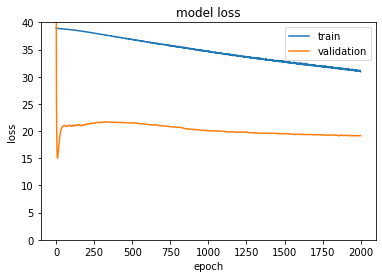

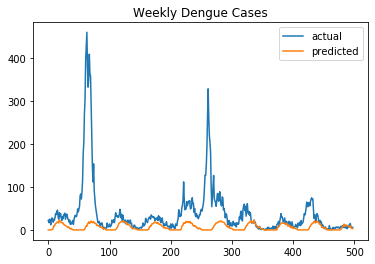

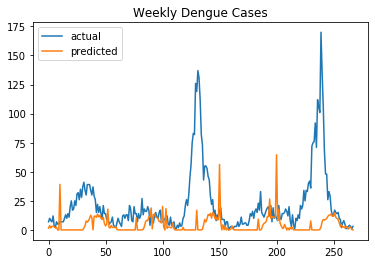

Forecast MAE: 29.40806518628526


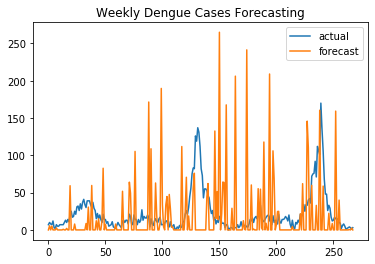

[0.0,
 5.550202,
 0.0,
 5.1728287,
 0.0,
 0.0,
 0.0,
 2.703539,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.86049795,
 0.0,
 0.0,
 2.0376518,
 0.0,
 0.0,
 59.27191,
 0.0,
 0.0,
 0.0,
 7.8806,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.588066,
 0.0,
 30.60132,
 0.0,
 0.0,
 59.57649,
 0.0,
 0.0,
 0.0,
 12.314802,
 0.0,
 14.914675,
 0.0,
 0.0,
 12.865908,
 82.68591,
 0.0,
 7.5565896,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.8854337,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 51.79108,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 64.02807,
 49.334606,
 0.0,
 0.0,
 0.0,
 105.248375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 171.4645,
 0.0,
 108.79194,
 0.0,
 0.0,
 0.0,
 62.913036,
 19.466787,
 0.0,
 0.0,
 9.529167,
 189.69505,
 33.91032,
 4.1313987,
 0.0,
 33.838375,
 44.74723,
 0.0,
 47.525497,
 28.523289,
 3.8621995,
 3.9455163,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 111.811745,
 0.0,
 0.0,
 23.794266,
 70.60776,
 0.0,
 18.729336,
 0.0,
 0.0,
 0.0,
 56.042747,
 76.0169,
 0

In [66]:
input_shape = (x.shape[1], x.shape[2])
model_sj = get_model(input_shape)
train_model(model_sj, data, epochs=2000)
plot_train_val(model_sj, data)
forecast_analysis(model_sj, data)

### Iquitos

In [71]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')
x, y = format_data(df_iq, lookback_window_iq, only_features=True)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 22, 150)
(370,)
(241, 22, 150)
(241,)
(129, 22, 150)
(129,)


(?, 22, 150)
Training...
Elapsed Time: 18.450055599212646


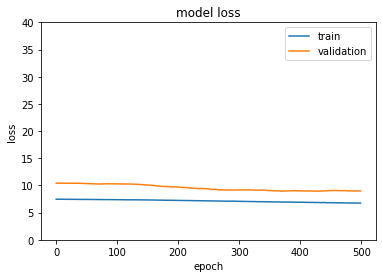

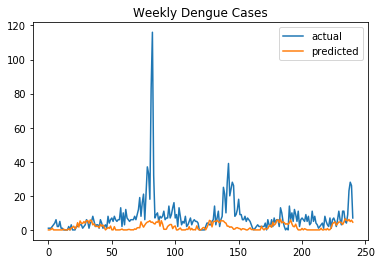

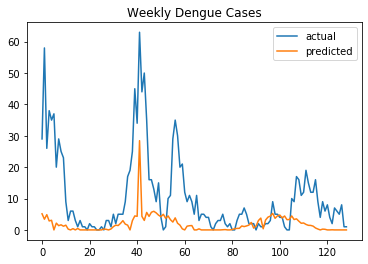

Forecast MAE: 9.323786759749055


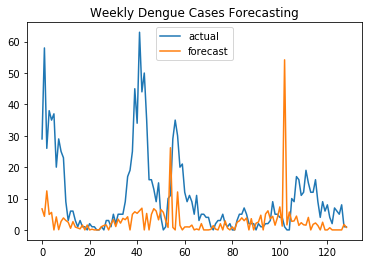

[6.711974,
 4.3237004,
 12.434257,
 4.932231,
 5.58324,
 0.0,
 4.151091,
 0.07592224,
 2.7040799,
 3.8172302,
 3.0188706,
 2.4570415,
 0.5293763,
 2.6469073,
 0.91133994,
 0.63238615,
 0.3401994,
 1.5444415,
 0.0,
 1.5546187,
 0.0,
 0.22697139,
 0.0,
 0.0,
 0.024115028,
 1.0370581,
 1.4176643,
 1.5932205,
 0.0,
 1.8899813,
 3.3107817,
 1.0725158,
 3.4400294,
 2.1620495,
 3.6886828,
 3.2591243,
 4.1926055,
 0.0,
 4.9686084,
 5.7755957,
 5.2898006,
 6.114399,
 6.920584,
 0.0,
 5.2495613,
 0.0,
 4.959241,
 6.762368,
 6.0218134,
 3.2158115,
 6.472216,
 5.6229463,
 3.0404067,
 0.77834123,
 26.193121,
 0.8153107,
 0.0,
 12.100005,
 1.4577948,
 0.0,
 0.9336305,
 0.9740473,
 0.9158804,
 1.5333558,
 0.0,
 0.30967525,
 0.0,
 2.0093613,
 0.0,
 0.0,
 0.0,
 0.15447603,
 1.3758465,
 0.2446467,
 0.0,
 1.976806,
 0.0,
 2.8815174,
 0.58710843,
 0.0,
 0.97316146,
 0.0,
 2.4435108,
 2.896133,
 3.854553,
 2.9373286,
 3.8126192,
 0.0,
 3.5817313,
 0.0,
 2.1349874,
 2.4981942,
 4.689719,
 0.0,
 5.068138,
 6

In [73]:
input_shape = (x.shape[1], x.shape[2])
model_iq = get_model(input_shape)
train_model(model_iq, data, epochs=500)
plot_train_val(model_iq, data)
forecast_analysis(model_iq, data)

## Model / Train / Forecast - Dense Time Model

In [204]:
K.clear_session()

### San Juan

In [109]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')


x, y = format_data(df_sj, lookback_window_sj, only_features=True)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 22, 170)
(766,)
(498, 22, 170)
(498,)
(268, 22, 170)
(268,)


(?, 22, 170)
Training...
Elapsed Time: 30.485268592834473


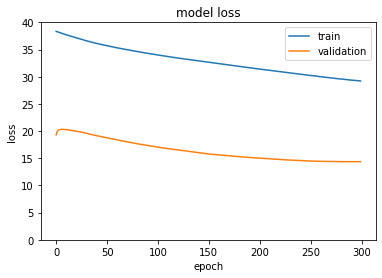

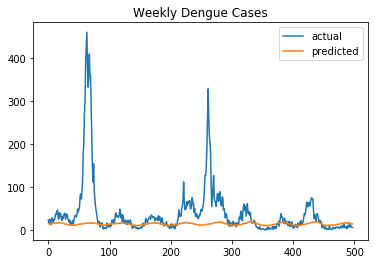

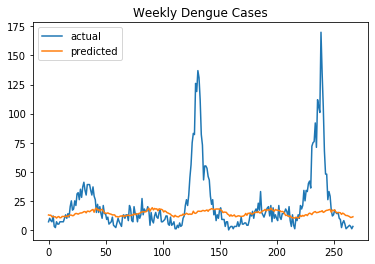

Forecast MAE: 14.428464996280955


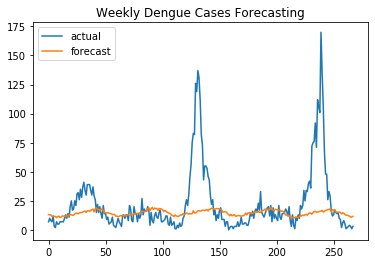

In [110]:
input_shape = (x.shape[1], x.shape[2]);
model_sj = get_model_dense(input_shape);
train_model(model_sj, data, epochs=300);
plot_train_val(model_sj, data);
forecast_analysis(model_sj, data);

### Iquitos

In [156]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')
x, y = format_data(df_iq, lookback_window_iq, only_features=True)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 22, 150)
(370,)
(241, 22, 150)
(241,)
(129, 22, 150)
(129,)


(?, 22, 150)
Training...
Elapsed Time: 33.8169469833374


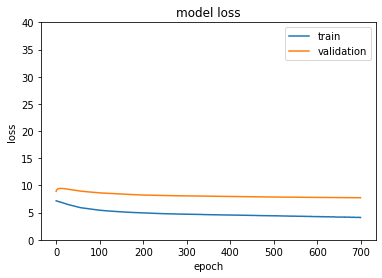

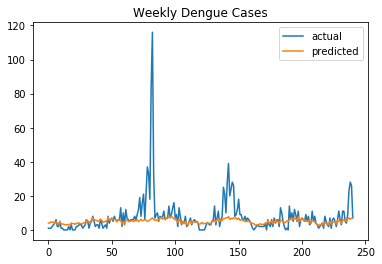

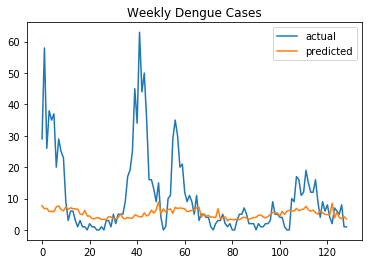

Forecast MAE: 7.720298356788103


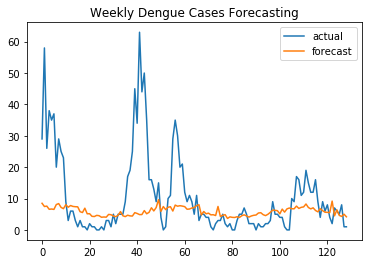

In [157]:
input_shape = (x.shape[1], x.shape[2]);
model_iq = get_model_dense(input_shape);
train_model(model_iq, data, epochs=700);
plot_train_val(model_iq, data);
forecast_analysis(model_iq, data);

## Model / Train / Forecast - TimeDistributed Model

In [165]:
K.clear_session()

### San Juan

In [166]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')


x, y = format_data(df_sj, lookback_window_sj, only_features=True)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 22, 170)
(766,)
(498, 22, 170)
(498,)
(268, 22, 170)
(268,)


(?, 22, 170)
Training...
Elapsed Time: 29.152371406555176


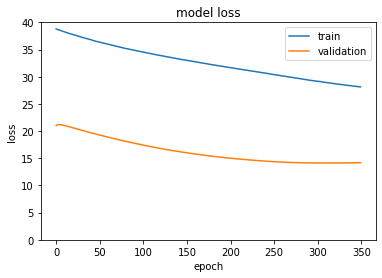

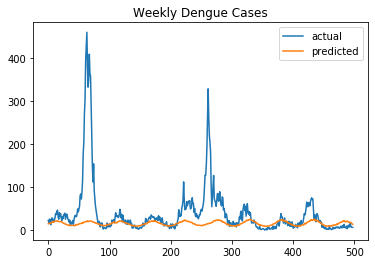

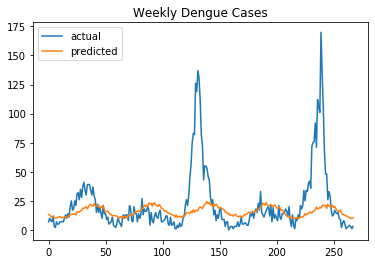

Forecast MAE: 14.78631718123137


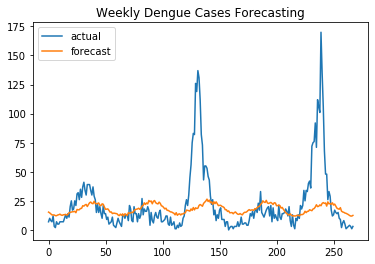

In [167]:
input_shape = (x.shape[1], x.shape[2]);
model_iq = get_model_timedist(input_shape);
train_model(model_iq, data, epochs=350);
plot_train_val(model_iq, data);
forecast_analysis(model_iq, data);

### Iquitos

In [169]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')
x, y = format_data(df_iq, lookback_window_iq, only_features=True)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 22, 150)
(370,)
(241, 22, 150)
(241,)
(129, 22, 150)
(129,)


(?, 22, 150)
Training...
Elapsed Time: 41.08545160293579


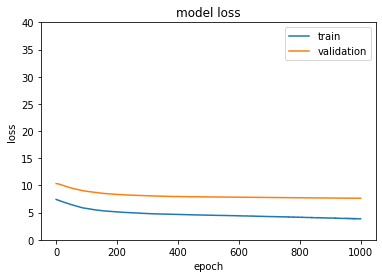

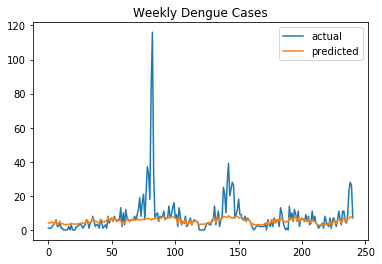

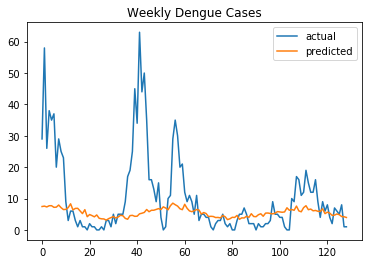

Forecast MAE: 7.643674501152926


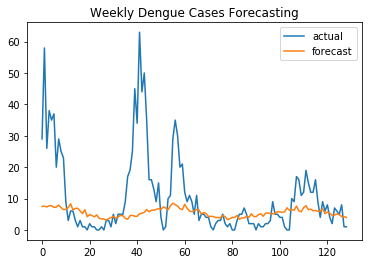

In [170]:
input_shape = (x.shape[1], x.shape[2]);
model_iq = get_model_timedist(input_shape);
train_model(model_iq, data, epochs=1000);
plot_train_val(model_iq, data);
forecast_analysis(model_iq, data);

## Model / Train / Forecast - LSTM Model

In [238]:
K.clear_session()

### San Juan

In [193]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')

df_sj = normalize_data(df_sj)

x, y = format_data(df_sj, lookback_window_sj, only_features=True, lstm=True)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 170, 22)
(766,)
(498, 170, 22)
(498,)
(268, 170, 22)
(268,)


(?, 170, 22)
Training...
Elapsed Time: 161.89913988113403


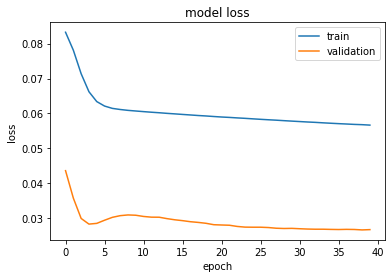

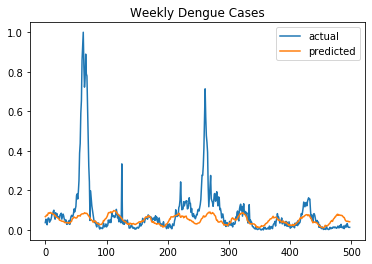

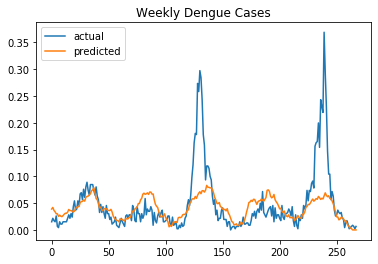

Forecast MAE: 0.026733937028374972


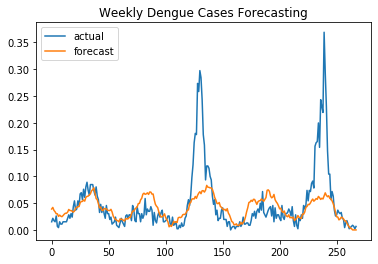

[0.039001424,
 0.041997153,
 0.036484092,
 0.03390232,
 0.03007402,
 0.030068275,
 0.025221573,
 0.027634984,
 0.025611093,
 0.02468941,
 0.026777947,
 0.0293136,
 0.031091949,
 0.031071091,
 0.033169392,
 0.038169928,
 0.0360653,
 0.036273535,
 0.034866665,
 0.03320608,
 0.035059158,
 0.040113,
 0.042207118,
 0.043037903,
 0.043627176,
 0.05072592,
 0.053072244,
 0.053177703,
 0.055876452,
 0.053665943,
 0.060774695,
 0.062442075,
 0.0630993,
 0.064963855,
 0.067460604,
 0.07309665,
 0.07488944,
 0.07864813,
 0.06876549,
 0.05848,
 0.05644728,
 0.0488456,
 0.04102811,
 0.042669494,
 0.0366819,
 0.03602635,
 0.039984323,
 0.039455373,
 0.039389115,
 0.03653575,
 0.03633092,
 0.036013387,
 0.038424153,
 0.03348713,
 0.025773535,
 0.02187906,
 0.019581446,
 0.017884178,
 0.01709281,
 0.015038632,
 0.020562094,
 0.019735819,
 0.01978166,
 0.01759009,
 0.01670765,
 0.021333037,
 0.020403007,
 0.020615572,
 0.023493748,
 0.023133764,
 0.030207913,
 0.03501216,
 0.034876954,
 0.038648713,
 0

In [196]:
input_shape = (x.shape[1], x.shape[2])
model_iq = get_model_lstm(input_shape)
train_model(model_iq, data, epochs=40)
plot_train_val(model_iq, data)
forecast_analysis(model_iq, data)

### Iquitos

In [239]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')
df_iq = normalize_data(df_iq)
x, y = format_data(df_iq, lookback_window_iq, only_features=True, lstm=True)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 150, 22)
(370,)
(241, 150, 22)
(241,)
(129, 150, 22)
(129,)


(?, 150, 22)
Training...
Elapsed Time: 289.7727036476135


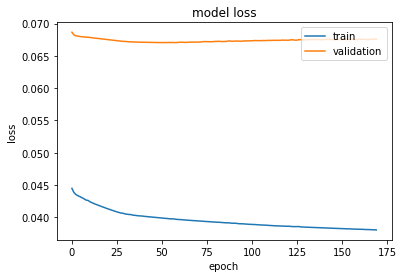

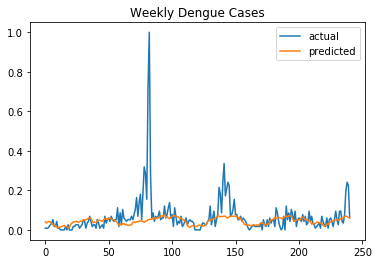

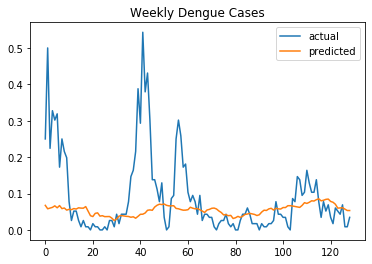

Forecast MAE: 0.06757344753974119


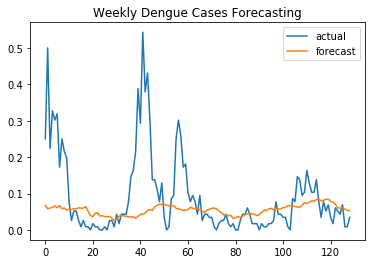

In [242]:
input_shape = (x.shape[1], x.shape[2]);
model_iq = get_model_lstm(input_shape);
train_model(model_iq, data, epochs=170);
plot_train_val(model_iq, data);
forecast_analysis(model_iq, data);

In [243]:
## inverse normalize error 

new_df = load_data(lookback_window_sj, city='sj')
nx = new_df.total_cases.values.reshape(-1, 1) #returns a numpy array
min_max_scaler_2 = preprocessing.MinMaxScaler()
min_max_scaler_2.fit(nx)

error = min_max_scaler_2.inverse_transform(np.array(0.026733937028374972).reshape(-1, 1))
print("SJ Forecast MAE: {}".format(error))

ndf = load_data(lookback_window_sj, city='iq')
nx2 = ndf.total_cases.values.reshape(-1, 1) #returns a numpy array
min_max_scaler_3 = preprocessing.MinMaxScaler()
min_max_scaler_3.fit(nx2)

error = min_max_scaler_2.inverse_transform(np.array(0.06757344753974119).reshape(-1, 1))
print("SJ Forecast MAE: {}".format(error))

SJ Forecast MAE: [[12.32434497]]
SJ Forecast MAE: [[31.15135932]]
